In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
import glob
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
ori_images = 'datasets/Images'
mask_images = 'datasets/Masks'

In [4]:
def load_data(split=0.2):
    images = [f for f in glob.glob(ori_images + "/*.jpg", recursive=True)]
    masks = [f for f in glob.glob(mask_images + "/*.jpg", recursive=True)]

    train_x, test_x = train_test_split(images, test_size=split, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=split, random_state=42)

    return (train_x, train_y), (test_x, test_y)

In [5]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (H, W, 3)
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    x = x.astype(np.float32)
    return x 

In [6]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    x = x.astype(np.float32)                    
    x = np.expand_dims(x, axis=-1)              
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([128, 128, 3])
    y.set_shape([128, 128, 1])
    return x, y

def tf_dataset(X, Y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [8]:
(train_x, train_y), (test_x, test_y) = load_data()

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 336 - 336
Test: 84 - 84


In [9]:
batch = 4
train_dataset = tf_dataset(train_x, train_y, batch)
valid_dataset = tf_dataset(test_x, test_y, batch)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)

    """ Bridge """
    b1 = conv_block(p2, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s2, 128)
    d2 = decoder_block(d1, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d2)

    """ Model """
    model = Model(inputs, outputs)
    return model

In [11]:
model = build_unet((128, 128, 3))
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [12]:
model_path = 'files/model.h5'
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True)
    ]

In [13]:
batch_size = 32
num_epoch = 20

In [14]:
model.fit(
    train_dataset.repeat(),
    epochs=num_epoch,
    validation_data=valid_dataset.repeat(),
    steps_per_epoch=len(train_x)//batch_size,
    validation_steps=len(test_x)//batch_size,
    callbacks=callbacks
)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.3966
Epoch 1: val_loss improved from inf to 0.44599, saving model to files\model.h5
10/10 [==============================] - 70s 6s/step - loss: 0.5410 - accuracy: 0.3966 - val_loss: 0.4460 - val_accuracy: 0.4241
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.4060 - accuracy: 0.4451
Epoch 2: val_loss improved from 0.44599 to 0.39539, saving model to files\model.h5
10/10 [==============================] - 75s 7s/step - loss: 0.4060 - accuracy: 0.4451 - val_loss: 0.3954 - val_accuracy: 0.4241
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.4281
Epoch 3: val_loss improved from 0.39539 to 0.32551, saving model to files\model.h5
10/10 [==============================] - 72s 7s/step - loss: 0.3576 - accuracy: 0.4281 - val_loss: 0.3255 - val_accuracy: 0.4241
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.3055 - accuracy:

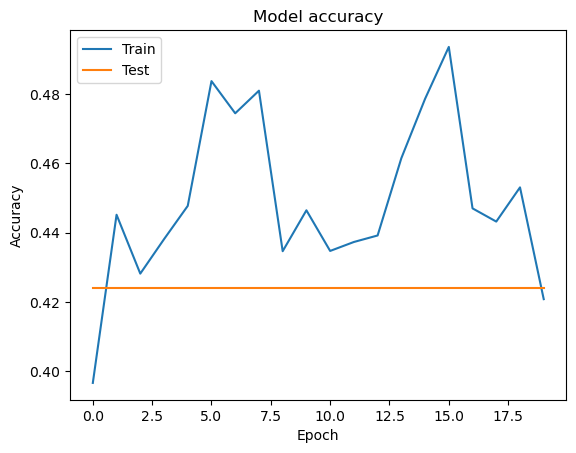

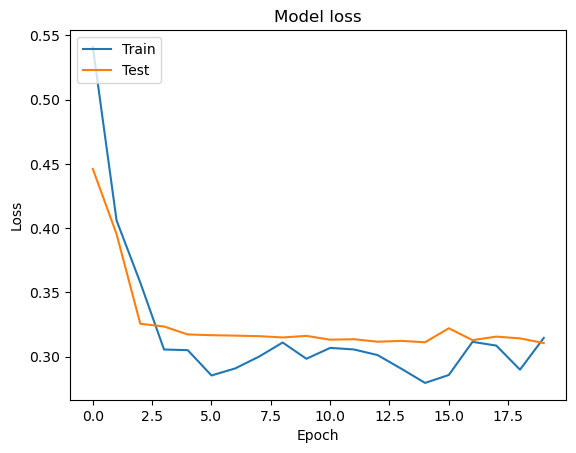

In [15]:
def graph():
    #Plot training & validation accuracy values
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

graph()